In [1]:
import numpy as np

In [2]:
class Perceptron():
    def __init__(self, threshold=0, lr=0.1, shuffle=False, niter=1):
        self.lr = lr
        self.w = None
        self.niter = niter
        self.shuffle = shuffle
        self.threshold = threshold
        self.erros_its = []   #armazena o número de erros no final da iteração
        self.w_its = []       #armazena os vetores de pesos ao final de todas as iterações
    
    def _C(self, y):
        return np.where(y<self.threshold, -1, 1)
    
    def _eval(self, X):
        y0 = np.dot(X, self.w)
        return self._C(y0)
            
    def predict(self, X):
        X_ = np.hstack((X, np.ones((X.shape[0],1))))
        return self._eval(X_)
        
    def fit(self, X, y):
        X = np.hstack((X, np.ones((X.shape[0],1))))
        self.w = np.zeros(X.shape[1])
        if self.shuffle:
            idx = np.random.permutation(
                    np.arange(X.shape[0], dtype=int))
            X = X[idx]
            y = y[idx]
        
        for i in range(self.niter):
            erros = []
            for linha, yt in zip(X, y):
                ychap = self._eval(linha)
                e = yt - ychap
                erros.append(e)
                self.w = self.w + (lr * e * linha)
#             print("it %d, %d erros" % 
#                   (i, np.count_nonzero(erros)))
            self.erros_its.append(np.count_nonzero(erros))
            self.w_its.append(self.w)
            if np.count_nonzero(erros) == 0:
                break
                
        self.w = self.w_its[np.argmin(self.erros_its)]
        print("melhor modelo restaurado (iteração %d)" % (np.argmin(self.erros_its)))

In [3]:
X = np.array([[-2, 1], [-1, 3], [0, 2], [1, 2], [2, 3]])
y = np.array([-1, -1, -1, 1, 1])
shuffle=False
niter = 100
threshold=0
lr = 0.1

In [4]:
percep = Perceptron(shuffle=shuffle, niter=niter, threshold=threshold, lr=lr)
percep.fit(X, y)

melhor modelo restaurado (iteração 2)


# Teste na base de dados iris

In [5]:
import pandas as pd
from sklearn.datasets import load_iris
import seaborn as sns

In [6]:
ds = load_iris(as_frame=True)

In [7]:
X = ds.frame[ds.frame.columns[-3:-1]].values
y_names = ds.target_names[ds.target]
y = ds.target

In [8]:
mask = (y_names=='versicolor') | (y_names=='virginica')
X = X[mask]
y = y[mask]
y_names = y_names[mask]

#transformar versicolor->-1, virginica = 1
y = np.where(y==1, -1, 1)

<Axes: >

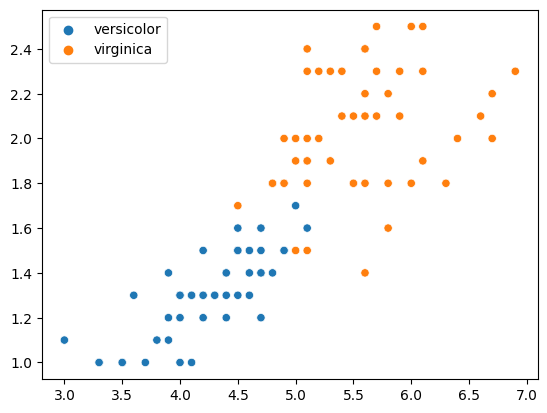

In [9]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_names)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=1)

In [12]:
niter=20
percep = Perceptron(niter=niter, lr=0.05, shuffle=False)
percep.fit(X_train, y_train)

melhor modelo restaurado (iteração 2)


In [13]:
pred = percep.predict(X_test)

In [14]:
pred

array([ 1,  1,  1,  1, -1,  1, -1, -1,  1, -1, -1, -1, -1,  1, -1,  1,  1,
       -1, -1, -1])

In [15]:
f1_score(y_test, pred), accuracy_score(y_test, pred)

(0.9473684210526316, 0.95)

In [16]:
def plot_fronteira(modelo, X, y, y_names, it, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_names, ax=ax)
    ax.set_title("%d" % (it))
    xfd = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 20)
    w = modelo.w_its[it]
    yfd = ((-w[0]/w[1]) * xfd) + (-w[2]/w[1])
    ax.plot(xfd, yfd, c='red')

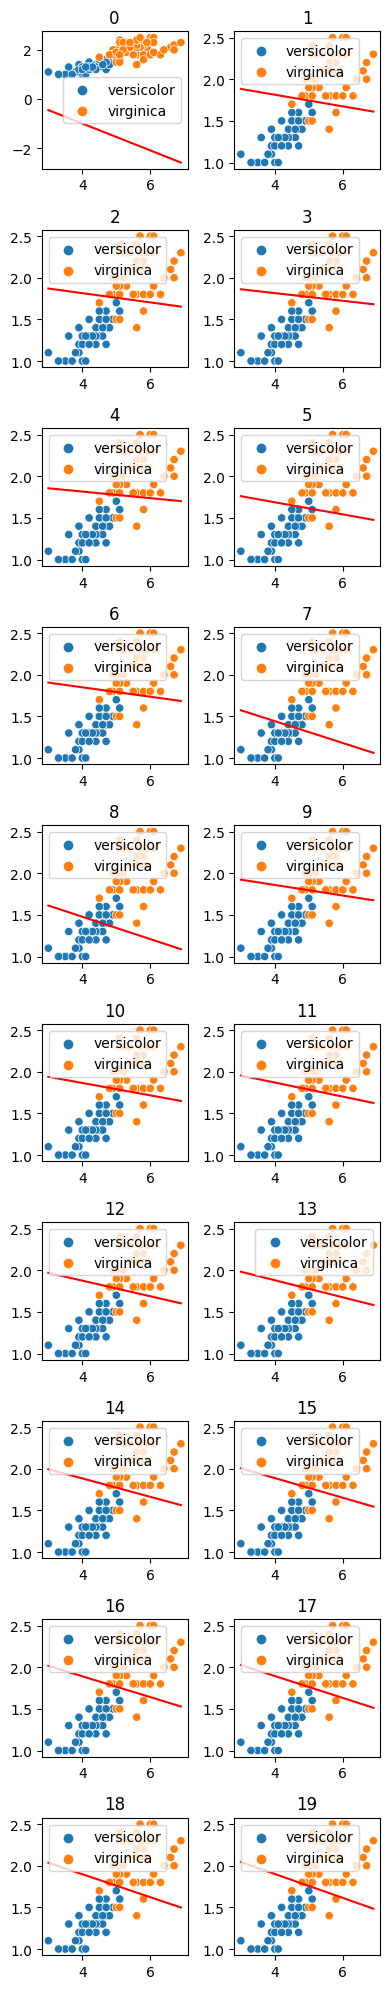

In [17]:
#plotar o modelo ao final de cada iteração
fig, axes = plt.subplots(nrows=niter//2, ncols=2, figsize=(4,20))
axes = axes.flatten()
for i, ax in enumerate(axes):
    plot_fronteira(percep, X, y, y_names, i, ax=ax)
fig.tight_layout()
plt.show()
plt.close('all')

2


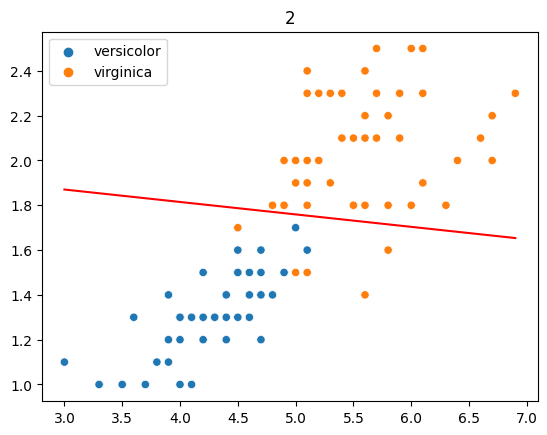

In [18]:
#plotar o melhor modelo (no treino)
print (np.argmin(percep.erros_its))
plot_fronteira(percep, X, y, y_names, np.argmin(percep.erros_its))

# Perceptron em Batch

In [19]:
class PerceptronBatch():
    def __init__(self, threshold=0, lr=0.1, 
                 batch_size=1, shuffle=False, niter=1):
        self.lr = lr
        self.w = None
        self.niter = niter
        self.shuffle = shuffle
        self.threshold = threshold
        self.batch_size = batch_size
        self.erros_its = []   #armazena o número de erros no final da iteração
        self.w_its = []       #armazena os vetores de pesos ao final de todas as iterações
    
    def _C(self, y):
        return np.where(y<self.threshold, -1, 1)
    
    def _eval(self, X):
        y0 = np.dot(X, self.w)
        return self._C(y0)
            
    def predict(self, X):
        X_ = np.hstack((X, np.ones((X.shape[0],1))))
        return self._eval(X_)
        
    def fit(self, X, y):
        X = np.hstack((X, np.ones((X.shape[0],1))))
        self.w = np.zeros(X.shape[1])
        if self.shuffle:
            idx = np.random.permutation(
                    np.arange(X.shape[0], dtype=int))
            X = X[idx]
            y = y[idx]
        
        for i in range(self.niter):
            erros = []
            
            for idx in range(0, X.shape[0], self.batch_size):
                grads = []
                for linha, yt in zip(X[idx:idx+self.batch_size], y[idx:idx+self.batch_size]):
                    ychap = self._eval(linha)
                    e = yt - ychap
                    erros.append(e)
                    grads.append(lr * e * linha)
                grads = np.mean(grads, axis=0)
                self.w = self.w + grads
                
            self.erros_its.append(np.count_nonzero(erros))
            self.w_its.append(self.w)
            if np.count_nonzero(erros) == 0:
                break
                
        self.w = self.w_its[np.argmin(self.erros_its)]
        print("melhor modelo restaurado (iteração %d)" % (np.argmin(self.erros_its)))

In [20]:
niter=20
percep = PerceptronBatch(niter=niter, lr=0.05, batch_size=2, shuffle=False)
percep.fit(X_train, y_train)

melhor modelo restaurado (iteração 17)


In [21]:
pred = percep.predict(X_test)

In [22]:
f1_score(y_test, pred), accuracy_score(y_test, pred)

(0.9473684210526316, 0.95)

In [23]:
#plotar o melhor modelo (no treino)
print (np.argmin(percep.erros_its))


17


17


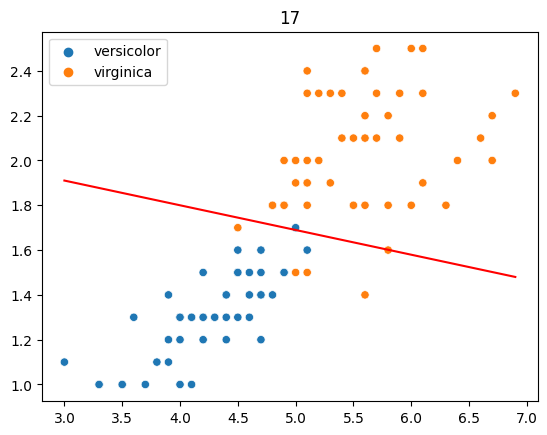

In [24]:
#plotar o melhor modelo (no treino)
print (np.argmin(percep.erros_its))
plot_fronteira(percep, X, y, y_names, np.argmin(percep.erros_its))

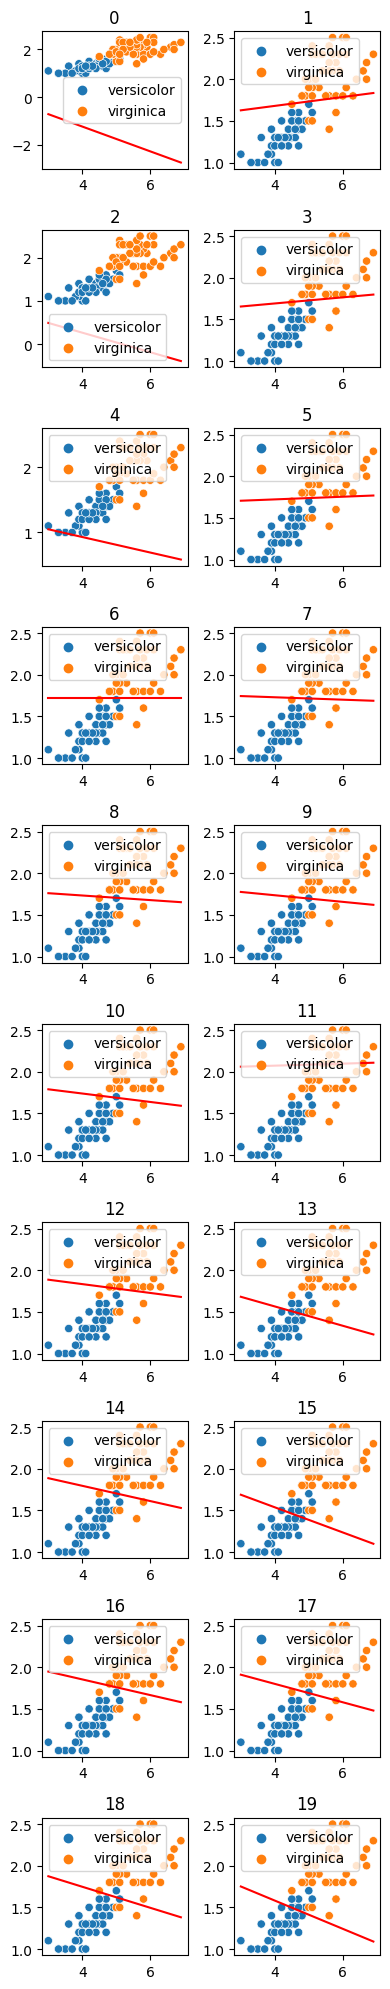

In [25]:
#plotar o modelo ao final de cada iteração
fig, axes = plt.subplots(nrows=niter//2, ncols=2, figsize=(4,20))
axes = axes.flatten()
for i, ax in enumerate(axes):
    plot_fronteira(percep, X, y, y_names, i, ax=ax)
fig.tight_layout()
plt.show()
plt.close('all')